In [2]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED
adp.SetStyle()

# Data

In [5]:
# get data
f = adp.UnpackTable(adp.path_csv+'\\AGN_NH_estimates_Kelly+2024_update_COSMOS.csv')
for k,v in f.items() :
    if(k == 'ID') : 
        f[k] = np.array(v, dtype=int)
    elif(k == 'GROUP') : 
        f[k] = np.array(v, dtype=str)
    else :
        f[k] = np.array(v, dtype=float)
print(list(f.keys()))

['ID', 'GROUP', 'Z', 'LOG_LIR', 'LOG_LX_INT', 'LOG_LX', 'LOG_LXLIM', 'LOG_LXIR_THEORY', 'LOG_NH_THEORY', 'SIG_POS_THEORY', 'SIG_NEG_THEORY', 'LOG_LXIR_INTRIN', 'LOG_NH_INTRIN', 'SIG_POS_INTRIN', 'SIG_NEG_INTRIN', 'LOG_NH_COSMOS']


In [4]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [6]:
def IDtoIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to get IRAC channels 
    key_cat, key_agn = match.match(id_catalog, id_agn)
    # calculate colors
    x = adp.IRACx(ch1[key_cat], ch3[key_cat])
    y = adp.IRACy(ch2[key_cat], ch4[key_cat])
    return(x, y)



# get colors 
f['x'], f['y'] = IDtoIRACcolors( f['ID'], id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 )

In [8]:
def SplitByColor(dataNew: dict) -> dict : 
    agnInfo = {}
    for color in ['RED', 'GRN', 'BLU'] : 
        idx = np.where(dataNew['GROUP'] == color)

        agnInfo[color] = {}
        for key, val in dataNew.items() : 
            agnInfo[color][key] = val[idx]

    return agnInfo

agnInfo = SplitByColor(f)
print(list(agnInfo.keys()))
print(list(agnInfo['RED'].keys()))

['RED', 'GRN', 'BLU']
['ID', 'GROUP', 'Z', 'LOG_LIR', 'LOG_LX_INT', 'LOG_LX', 'LOG_LXLIM', 'LOG_LXIR_THEORY', 'LOG_NH_THEORY', 'SIG_POS_THEORY', 'SIG_NEG_THEORY', 'LOG_LXIR_INTRIN', 'LOG_NH_INTRIN', 'SIG_POS_INTRIN', 'SIG_NEG_INTRIN', 'LOG_NH_COSMOS', 'x', 'y']


# Plot

In [24]:
def PlotColorColorNH_ax(
        ax,                     # axis for plotting
        x,y,                    # x and y coordinants to fit colorbar to 
        nh, vmin, vmax,         # column density 
        zfullText=''            # redshift range string
):
    # plot data
    ax.scatter(x, y, marker='D', s=3, c=nh, cmap= plt.cm.get_cmap('copper_r',9), vmin=vmin, vmax=vmax,  label='$N_H$ (n='+str(len(x))+')')   
    # decorations
    adp.PlotDonleyWedge_ax(ax)
    adp.AddText_z_ax(ax, zfullText)
    adp.AddText_n_ax(ax,len(x))
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([-0.7,1.0])
    ax.set_ylim([-0.7,1.0])
    ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

def PlotColorColorNH( f, save=''):
    
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')

        # determine colorbar values for NH
    nh = f['LOG_NH_INTRIN']
    nh_min = np.nanmin(nh)
    nh_max = np.nanmax(nh)

    PlotColorColorNH_ax(
        ax= ax,
        x = f['x'],
        y = f['y'],
        nh=nh, vmin=nh_min, vmax=nh_max,
        zfullText='$0 < z \leq 6$'
    )

    SED.PlotColorbar_ax(
        ax=ax, 
        cmap=plt.cm.get_cmap('copper_r',9), 
        min=nh_min, 
        max=nh_max, 
        n_ticks=10, 
        label='$\log( \; N_H [cm^{-2}] \;)$',
        location='right',
    )
    # lables 
    plt.xlabel('$\log(f_{5.8um}/f_{3.6um})$')
    plt.ylabel('$\log(f_{8.0um}/f_{4.5um})$')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

C:\Users\polar\AppData\Local\Temp\ipykernel_6184\1546898432.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(x, y, marker='D', s=3, c=nh, cmap= plt.cm.get_cmap('copper_r',9), vmin=vmin, vmax=vmax,  label='$N_H$ (n='+str(len(x))+')')
C:\Users\polar\AppData\Local\Temp\ipykernel_6184\1546898432.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('copper_r',9),


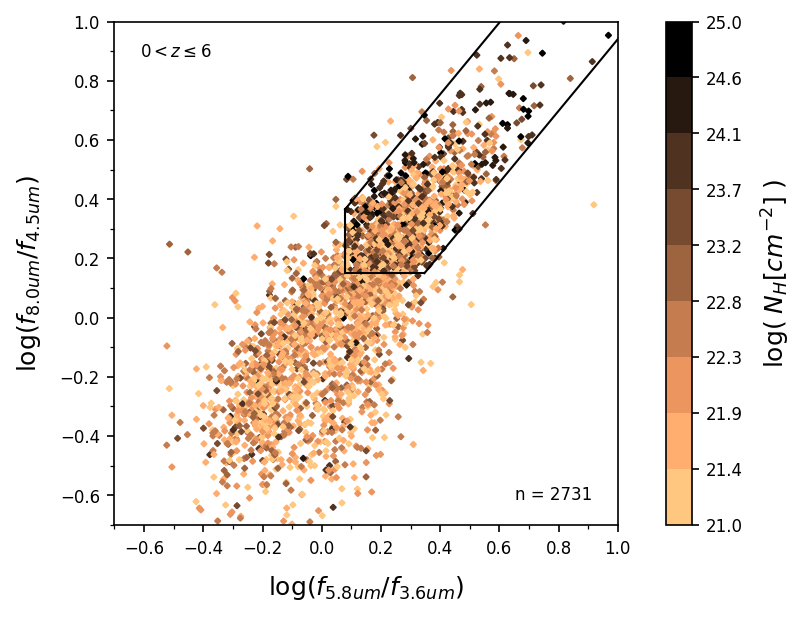

In [25]:
PlotColorColorNH(f)
# TODO f is all Christophers stuff. make list of combined values